## House Price Prediction With MLFLOW

In this tutorials we will 

- Run a hyperparameter tuning while training a model
- Log every Hyperparameter and metrics in the MLFLOW UI 

- Compare the results of the various runs in the MLflow UI

- Choose the best run and register it as a model

##  MLflow Concepts Used in This Project

MLflow is an open-source platform to manage the complete machine learning lifecycle. In this project, we use the following key components:

### 1. `mlflow.start_run()`
- Starts a new MLflow run.
- All parameters, metrics, and models logged within the `with mlflow.start_run():` block are tracked under this run.

### 2. `mlflow.log_param()`
- Logs a single parameter (e.g., hyperparameter values) to the current run.
- This helps compare how different configurations affect performance.

### 3. `mlflow.log_metric()`
- Logs a performance metric (e.g., Mean Squared Error `mse`) to the current run.
- Metrics can be visualized and compared across different runs in the MLflow UI.

### 4. `mlflow.set_tracking_uri()`
- Sets the tracking server URI where MLflow logs will be stored.
- In our case, we use `http://127.0.0.1:5000` which points to a local MLflow tracking server.

### 5. `mlflow.sklearn.log_model()`
- Logs a trained `scikit-learn` model as an artifact of the current run.
- Optionally, it can include a model **signature** for input/output schema validation.

### 6. `registered_model_name`
- Optional: Registers the model in the **MLflow Model Registry** under a given name (e.g., `"Best Randomforest Model"`).
- Useful for model versioning and deployment workflows.

### 7. `infer_signature()`
- Automatically infers the input and output schema of the model.
- This is useful for ensuring data consistency during model serving or production use.

---

### 🧪 Accessing the MLflow Tracking UI
After running the training script, we can launch the MLflow UI with:


Then open the browser and go to: [http://127.0.0.1:5000](http://127.0.0.1:5000)

There, we can:
- Browse runs and experiments
- Compare hyperparameters and metrics
- Download or deploy trained models
- Track artifacts and versioned models


### Data Preparation

In [11]:
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing

housing=fetch_california_housing()
print(housing)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]), 'frame': None, 'target_names': ['MedHouseVal'], 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n-

In [2]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [3]:
## Prepraing the dataset
data=pd.DataFrame(housing.data,columns=housing.feature_names)
data['Price']=housing.target

data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


### Train test split, Model Hyperparameter Tuning,MLFLOW Experiments

In [4]:
from urllib.parse import urlparse
## Independent and Dependent features
X=data.drop(columns=["Price"])
y=data["Price"]

In [8]:
## Hyperparameter tuning using Grid Searchcv

def hyperparameter_tuning(modelname, X_train,y_train,param_grid):
    rf=modelname()
    grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=3,n_jobs=-1,verbose=2,
                             scoring="neg_mean_squared_error")
    grid_search.fit(X_train,y_train)
    return grid_search

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

def run_mlflow_experiment(model_class, model_name, X_train, X_test, y_train, y_test, param_grid, experiment_name):
    """
    Runs an MLflow experiment for a given regression model class.
    
    Parameters:
    - model_class: The regression model class (e.g., GradientBoostingRegressor)
    - model_name: String identifier for the model (e.g., "GradientBoosting")
    - X_train, X_test, y_train, y_test: Dataset splits
    - param_grid: Hyperparameter grid for tuning
    - experiment_name: Name of the MLflow experiment
    """
    
    # Set MLflow experiment and URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment(experiment_name)

    signature = infer_signature(X_train, y_train)

    with mlflow.start_run(run_name=model_name):
        # Hyperparameter tuning (you must have this function defined)
        grid_search = hyperparameter_tuning(model_class, X_train, y_train, param_grid)
        best_model = grid_search.best_estimator_

        # Evaluation
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)

        # Log params
        for param, value in grid_search.best_params_.items():
            mlflow.log_param(param, value)
        
        # Log metrics
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        # Log model
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        if tracking_url_type_store != 'file':
            mlflow.sklearn.log_model(best_model, "model", registered_model_name=f"Best_{model_name}_Model")
        else:
            mlflow.sklearn.log_model(best_model, "model", signature=signature)

        print(f"[{model_name}] Best Params: {grid_search.best_params_} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models_to_test = [
    (RandomForestRegressor, "RandomForest"),
    (GradientBoostingRegressor, "GradientBoosting"),
    (Ridge, "Ridge"),
    (Lasso, "Lasso"),
    (DecisionTreeRegressor, "DecisionTree"),
    (SVR, "SVR")
]

param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },
    "Ridge": {"alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"alpha": [0.01, 0.1, 1.0]},
    "DecisionTree": {"max_depth": [5, 10, None]},
    "SVR": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
}
## Split data into training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

for model_class, model_name in models_to_test:
    run_mlflow_experiment(
        model_class=model_class,
        model_name=model_name,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        param_grid=param_grids[model_name],
        experiment_name="HousePrice_Regression_Experiments"
    )


2025/04/06 20:11:32 INFO mlflow.tracking.fluent: Experiment with name 'HousePrice_Regression_Experiments' does not exist. Creating a new experiment.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=5, min_samples_leaf=

2025/04/06 20:12:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_RandomForest_Model'.
2025/04/06 20:12:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_RandomForest_Model, version 1
Created version '1' of model 'Best_RandomForest_Model'.


[RandomForest] Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} | MSE: 0.2710 | RMSE: 0.5205 | MAE: 0.3559
🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/967927712321335237/runs/6e3e68aaf4a7455191b8013dd5995ea4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/967927712321335237
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   3.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   3.9s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   6.0s
[CV] END ..learnin

2025/04/06 20:12:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_GradientBoosting_Model'.
2025/04/06 20:12:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_GradientBoosting_Model, version 1
Created version '1' of model 'Best_GradientBoosting_Model'.


[GradientBoosting] Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200} | MSE: 0.2057 | RMSE: 0.4535 | MAE: 0.3051
🏃 View run GradientBoosting at: http://127.0.0.1:5000/#/experiments/967927712321335237/runs/9df7fb00618c4f0ab48ed05e8f6a752e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/967927712321335237
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .........................................alpha=10.0; total time=   0.0s[CV] END ..........................................alpha=0.1; total time=   0.0s

[CV] END ..........................................alpha=1.0; total time=   0.0s[CV] END ..........................................alpha=1.0; total time=   0.0s[CV] END .........................................alpha=10.0; total time=   0.0s[CV] END .........................................alpha=10.0; total time=   0.0s



[CV] END ..........................................alpha=0.1; total time=   0.0s[CV] END .............................

2025/04/06 20:12:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_Ridge_Model'.
2025/04/06 20:12:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Ridge_Model, version 1
Created version '1' of model 'Best_Ridge_Model'.


[Ridge] Best Params: {'alpha': 10.0} | MSE: 0.4856 | RMSE: 0.6969 | MAE: 0.5201
🏃 View run Ridge at: http://127.0.0.1:5000/#/experiments/967927712321335237/runs/1dee7b49c280490eb1159b34a3d62eec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/967927712321335237
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .............

2025/04/06 20:12:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_Lasso_Model'.
2025/04/06 20:12:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_Lasso_Model, version 1
Created version '1' of model 'Best_Lasso_Model'.


[Lasso] Best Params: {'alpha': 0.01} | MSE: 0.4949 | RMSE: 0.7035 | MAE: 0.5262
🏃 View run Lasso at: http://127.0.0.1:5000/#/experiments/967927712321335237/runs/051e5e633d1e4feeaaf32ccbe9fdf1a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/967927712321335237
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .......................................max_depth=10; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .............

2025/04/06 20:12:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Best_DecisionTree_Model'.
2025/04/06 20:12:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Best_DecisionTree_Model, version 1
Created version '1' of model 'Best_DecisionTree_Model'.


[DecisionTree] Best Params: {'max_depth': 10} | MSE: 0.3812 | RMSE: 0.6174 | MAE: 0.4124
🏃 View run DecisionTree at: http://127.0.0.1:5000/#/experiments/967927712321335237/runs/8dd69a14b84545509f5da87d32cf94fd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/967927712321335237
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................................C=1, kernel=rbf; total time=  16.7s
[CV] END ..................................C=0.1, kernel=rbf; total time=  16.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=  16.9s
[CV] END ....................................C=1, kernel=rbf; total time=  16.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=  17.0s
[CV] END ...................................C=10, kernel=rbf; total time=  16.9s
[CV] END ....................................C=1, kernel=rbf; total time=  17.1s
[CV] END ...................................C=10, kernel=rbf; total time=   8.9s
[CV] 

![](<attachment:Capture d’écran du 2025-04-06 20-29-28.png>)Capture d’écran du 2025-04-06 20-29-28.png
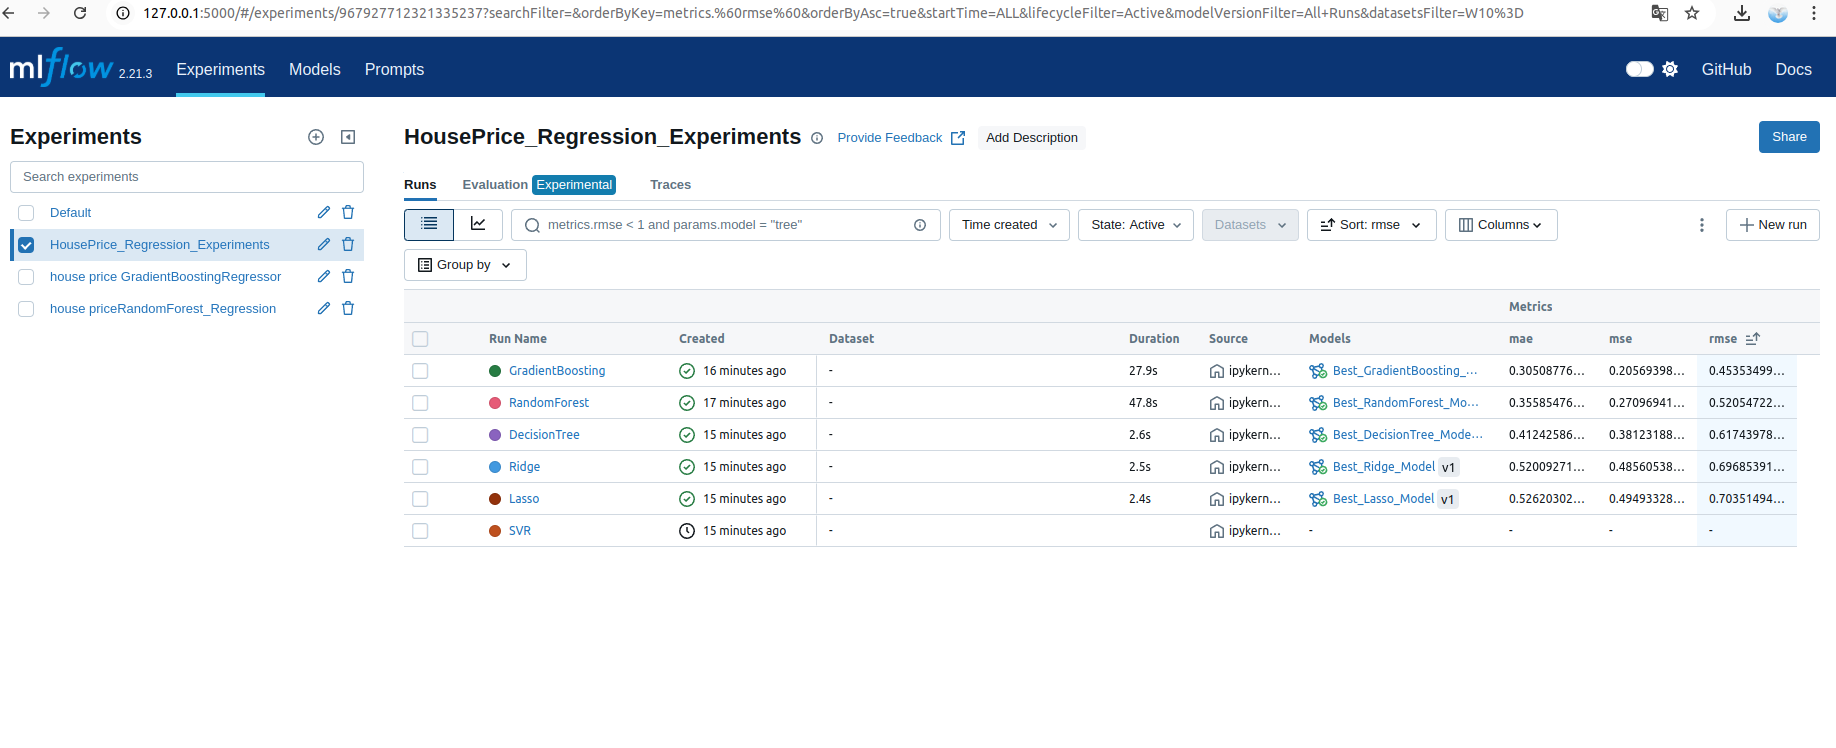

![Capture d’écran du 2025-04-06 20-29-55.png](<attachment:Capture d’écran du 2025-04-06 20-29-55.png>)
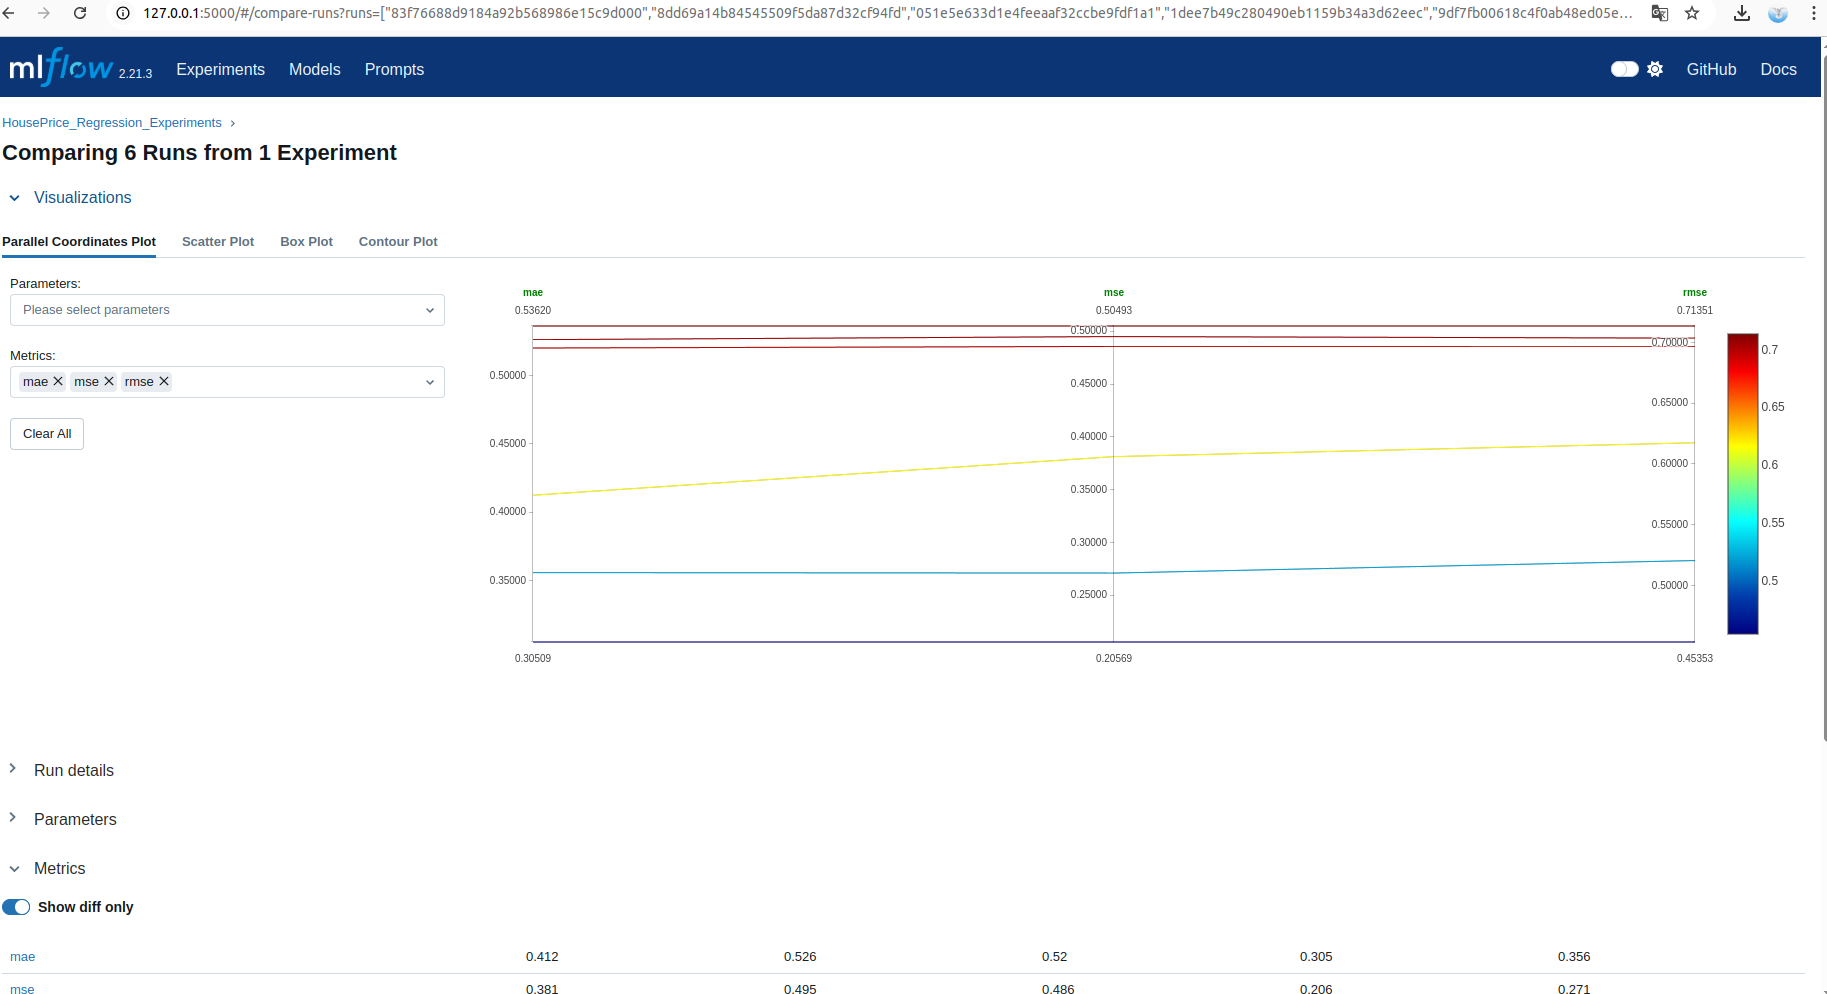

![Capture d’écran du 2025-04-06 20-30-33.png](<attachment:Capture d’écran du 2025-04-06 20-30-33.png>)
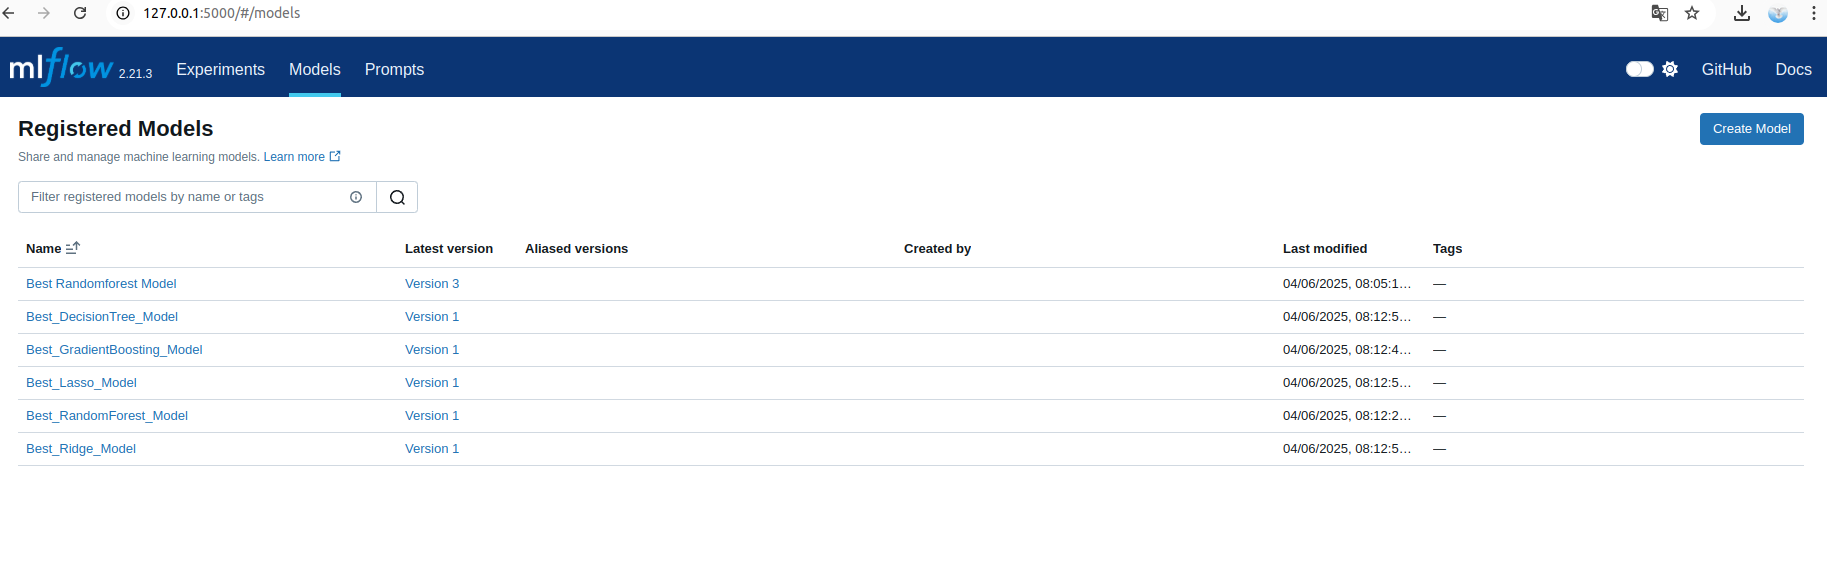